In [164]:
from mordecai import Geoparser
import pandas as pd
import os
import geopandas
from geopandas.tools import sjoin
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import sys
import docker
import numpy as np
import bs4
import urllib.request
import re

In [162]:
# image = "elasticsearch:5.5.2"

# volumes = {os.getcwd() + "/geonames_index/" : {'bind': "/usr/share/elasticsearch/data", 'mode': 'rw'}}

# client = docker.from_env()

# client.images.pull(image)

# client.containers.run(image, volumes=volumes, ports={'9200/tcp':('127.0.0.1' , 9200)}, detach=True)

In [209]:
def create_new_df(tweet_df, column_name='locs'):
    loc_name = []
    lats = []
    lons = []

    for loc in tweet_df[column_name]:
        try:
            for location, coord in loc.items():
                loc_name.append(location)
                lats.append(float(coord[0]))
                lons.append(float(coord[1]))
        except:
            continue

    location_df = pd.DataFrame(
        {'Location Extracted': loc_name,
         'Latitude': lats,
         'Longitude': lons})
    
    return location_df

def generate_overlay_plot(tweet_df, column_name='locs'):
    location_df = create_new_df(tweet_df, column_name)
    loc_gdf = geopandas.GeoDataFrame(
        location_df, geometry=geopandas.points_from_xy(location_df.Longitude, location_df.Latitude))
    
    filename = "/Users/thatcher/Documents/Data/tl_2017_us_state/tl_2017_us_state.shp"

    df = geopandas.read_file(filename)
    # Plot correctly
    fig, ax = plt.subplots(figsize = (75, 75))
    ax.set_aspect('equal')
    basemap = df.plot(ax=ax, edgecolor='black')
    return ax, loc_gdf.plot(ax=ax, marker='o', color='orange', markersize=35);

def lat_lon_to_points(lat_lon_list):
    point_list = []
    for x in lat_lon_list:
        point_list.append(Point(x))
    
    return point_list
        
def points_in_shp(points_list, shapefile_gpd):
    
    pnts = geopandas.GeoDataFrame(geometry=points_list, index=range(0, len(points_list)))
    pointInPolys = sjoin(pnts, shapefile_gpd, how='left')
    grouped = pointInPolys.groupby('index_right', as_index=False)
    
    return pointInPolys, grouped

def extract_webpage_locations(df):
    link_dict = {}
    for link in url_df['URLs']:

        try:
            webpage=str(urllib.request.urlopen(link.strip("[]''")).read())
            soup = bs4.BeautifulSoup(webpage, 'html.parser')
            paragraphs = []
            headers = []

            link_dict[link.strip("[]''")] = {'Headers': [], 'Paragraphs': []}

            for h in soup.find_all(re.compile('^h[1-6]$')):
                headers.append(h.get_text().strip('\n ') + "\n")

            link_dict[link.strip("[]''")]['Headers'] = headers 

            for p in soup.find_all('p'):
                paragraphs.append(p.get_text().strip('\n ') + "\n")

            link_dict[link.strip("[]''")]['Paragraphs'] = paragraphs

        except Exception as e:
            print(e)
            continue
        
    web_df = pd.DataFrame.from_dict(link_dict, orient='index')
    
    return web_df


In [196]:
geo = Geoparser()

def parse_tweet(df):
    locations = geo.geoparse(df['Full_Text'])
    loc_list = {}
    if locations:
        for loc in locations:
            try:
                if(loc['country_predicted'] == "USA"):
                    loc_list[loc['geo']['place_name']] = (loc['geo']['lat'], loc['geo']['lon'])
            except:
                continue
        
        return loc_list
    else:
        return np.nan

csv_file = "/Users/thatcher/Documents/GraduateSchool/Research/NewsDesertsData/2018_10_08_04_stream_1_clean_location.csv"
tweet_df = pd.read_csv(csv_file, sep='\t')
tweet_df['locs'] = tweet_df.apply(parse_tweet, axis = 1)

In [99]:
# points, groups = points_in_shp(loc_gdf['geometry'], df)
# print(points)

In [197]:
url_df = tweet_df[tweet_df['URLs'] != '[]']
url_df

,Unnamed: 0,Unnamed: 0.1,TweetID,Timestamp,Full_Text,In_Reply_To_User_ID,User_ID,User_Name,User_Screen_Name,Coordinates,...,Bounding_Box,Quoted_Status_ID,Retweeted_Status,Hashtags,URLs,User_Mentions,Media,Language,Locations,locs
1,1,1,1049266920996962305,2018-10-08 11:55:03,b'\xe2\x80\x9c Illinois State Senator Michael ...,NaN,599425458,John Dussman,Chichamberevent,NaN,...,[],0,[],[],['https://twitter.com/i/web/status/10492669209...,{},[],en,"['GRANT, ILLINOIS', 'CHAMPION, ILLINOIS', 'ENT...",NaN
10,10,10,1049266922850680834,2018-10-08 11:55:03,b'Engel &amp; V\xc3\xb6lkers Florida Launch Gr...,NaN,2228327040,LinkedInMoreBiz,LinkdInMoreBiz,NaN,...,[],0,[],[],['http://dlvr.it/Qmfy4V'],{},[],de,"[('FLORIDA, OHIO', (41.3237, -84.2004)), ('FLO...","{'Florida': ('28.75054', '-82.5001')}"
11,11,11,1049266922875998214,2018-10-08 11:55:03,b'',NaN,2812684166,İBB RetweeT,ibbRT,NaN,...,[],0,1049266066109751296,[],['http://www.ibb.gov.tr/tr-TR/Documents/meclis...,{'ibbmeclis': 858228415},[],tr,[],NaN
15,15,15,1049266920929841152,2018-10-08 11:55:03,b'Prop de 40 inscrits dem\xc3\xa0 a #Girona am...,NaN,484715252,Sandra Font,sandrafont19,NaN,...,[],0,[],['Girona'],['https://twitter.com/i/web/status/10492669209...,"{'CapitalCellNet': 2887377069, 'XarxaBagi': 29...",[],ca,[],{}
17,17,17,1049266923110842369,2018-10-08 11:55:03,b'Wo to kngna ne khud kha ki uska rep bhi kiya...,NaN,1001689682772746241,Geeta Prajapati,GeetaPr99601911,NaN,...,[],1049209252177502209,[],[],['https://twitter.com/i/web/status/10492669231...,{},[],in,[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9090,9090,9090,1049267727079288833,2018-10-08 11:58:15,b'New Fossil Womens Oklahoma Collegiate-Bracel...,NaN,1607173465,College Football,holidayhqteam,NaN,...,[],0,[],[],['http://rover.ebay.com/rover/1/711-53200-1925...,{},[],en,"[('FOSSIL, OREGON', (44.998, -120.2147)), ('OK...",NaN
9092,9092,9092,1049267727146373120,2018-10-08 11:58:15,b'@ZandbergRAZEM @Platforma_org @pisorgpl Nie ...,4.008009e+09,818875619006091266,Dawid 🇵🇱🇯🇵,Datyka0809,NaN,...,[],0,[],[],['http://www.sejm.gov.pl/sejm7.nsf/agent.xsp?s...,"{'Platforma_org': 53003895, 'pisorgpl': 158776...",[],pl,[],NaN
9094,9094,9094,1049267727158988800,2018-10-08 11:58:15,b'',NaN,884197302461751296,Michele Bosserman,MicheleBoss6971,NaN,...,[],1049241930452914177,1049265677352284165,"['WalkAway', 'VoteRED2018', 'DrainTheSwamp']",['https://twitter.com/mitchellvii/status/10492...,{'Mike_Beacham': 829735580},[],und,[],NaN
9095,9095,9095,1049267727217713153,2018-10-08 11:58:15,b'',NaN,911522491,Carol,cperusich,NaN,...,[],1048968569919348738,1049001762076721152,[],['https://twitter.com/FaceTheNation/status/104...,{'NoahShachtman': 15728161},[],en,[],NaN


In [157]:
def extract_webpage_locations(web_df):
    link_dict = {}
    for link in url_df['URLs']:

        try:
            webpage=str(urllib.request.urlopen(link.strip("[]''")).read())
            soup = bs4.BeautifulSoup(webpage, 'html.parser')
            paragraphs = []
            headers = []

            link_dict[link.strip("[]''")] = {'Headers': [], 'Paragraphs': []}

            for h in soup.find_all(re.compile('^h[1-6]$')):
                headers.append(h.get_text().strip('\n ') + "\n")

            link_dict[link.strip("[]''")]['Headers'] = headers 

            for p in soup.find_all('p'):
                paragraphs.append(p.get_text().strip('\n ') + "\n")

            link_dict[link.strip("[]''")]['Paragraphs'] = paragraphs

        except Exception as e:
            print(e)
            continue
        
    web_df = pd.DataFrame.from_dict(link_dict, orient='index')
    
    return web_df
        
    
    
# print(soup.get_text())

<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>


<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>


<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>
<class 'Exception'>


In [201]:
tweet_df = tweet_df.fillna("NAN")
new_df = tweet_df[tweet_df['locs'] != "NAN"]
new_df

,Unnamed: 0,Unnamed: 0.1,TweetID,Timestamp,Full_Text,In_Reply_To_User_ID,User_ID,User_Name,User_Screen_Name,Coordinates,...,Bounding_Box,Quoted_Status_ID,Retweeted_Status,Hashtags,URLs,User_Mentions,Media,Language,Locations,locs
3,3,3,1049266922347528193,2018-10-08 11:55:03,b'Hi Im @CoryBooker and Im running for Preside...,NAN,183725338,The Cheese,colbymonterey,NAN,...,[],0,1049129529627688960,[],[],"{'CoryBooker': 15808765, 'AppSame': 242618658}",[],en,[],{}
7,7,7,1049266922716647431,2018-10-08 11:55:03,b'@drfhutchinson @USAWrestling @MOKWCKS @salin...,NAN,2485385736,Jerry bowen,jerrybowen74,NAN,...,[],0,1049145615484166144,[],[],"{'drfhutchinson': 285414565, 'USAWrestling': 2...",[],en,"[('DAY, MINNESOTA', (45.7091, -93.3794)), ('DA...","{'Kansas': ('38.50029', '-98.50063')}"
10,10,10,1049266922850680834,2018-10-08 11:55:03,b'Engel &amp; V\xc3\xb6lkers Florida Launch Gr...,NAN,2228327040,LinkedInMoreBiz,LinkdInMoreBiz,NAN,...,[],0,[],[],['http://dlvr.it/Qmfy4V'],{},[],de,"[('FLORIDA, OHIO', (41.3237, -84.2004)), ('FLO...","{'Florida': ('28.75054', '-82.5001')}"
13,13,13,1049266922733416448,2018-10-08 11:55:03,b'Ukrainian Secret Service has published the n...,NAN,802968876212428801,🌺jess🌺,__RedLily__,NAN,...,[],0,1048881218559901697,[],[],{'olex_scherba': 163018653},[],en,"[('MANY, LOUISIANA', (31.5663, -93.4777)), ('S...",{}
15,15,15,1049266920929841152,2018-10-08 11:55:03,b'Prop de 40 inscrits dem\xc3\xa0 a #Girona am...,NAN,484715252,Sandra Font,sandrafont19,NAN,...,[],0,[],['Girona'],['https://twitter.com/i/web/status/10492669209...,"{'CapitalCellNet': 2887377069, 'XarxaBagi': 29...",[],ca,[],{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9088,9088,9088,1049267727108427776,2018-10-08 11:58:15,b'Hey @taylorswift13 - You just endorsed a Dem...,NAN,2863158308,Brenda Baller,DenverPower,NAN,...,[],0,1049098893420634113,[],[],"{'taylorswift13': 17919972, 'charliekirk11': 2...",[],en,"[('TENNESSEE, ILLINOIS', (40.4112, -90.8361)),...","{'Tennessee': ('35.75035', '-86.25027')}"
9089,9089,9089,1049267726919852032,2018-10-08 11:58:15,b'the reason i am happy bts are in england is ...,NAN,387035021,speak yourself,googitae,NAN,...,[],0,[],[],['https://twitter.com/i/web/status/10492677269...,{},[],en,"[('HAPPY, TEXAS', (34.7416, -101.8572)), ('ENG...",{}
9099,9099,9099,1049267727624491016,2018-10-08 11:58:15,b'The mid-terms are NOT a MUST-WIN for Conserv...,NAN,470478296,Siridh,siridh1056,NAN,...,[],0,1049080796445925381,[],[],{'Education4Libs': 817661098988019712},[],en,[],{}
9102,9102,9102,1049267727993643008,2018-10-08 11:58:15,b'Spooktober w @koons_cami. Second installment...,NAN,904166562491400193,Cami Koons,koons_cami,NAN,...,[],0,1049154814385541120,[],[],"{'annajbartle': 2261813899, 'koons_cami': 9041...",[],en,"['BLAIR, TEXAS']","{'Texas': ('31.25044', '-99.25061')}"


,Headers,Paragraphs
https://twitter.com/i/web/status/1049266920996962305,"[Saved searches\n, Tweets\n, \n John Dussma...",[We\'ve detected that JavaScript is disabled i...
http://dlvr.it/Qmfy4V,[Engel & V\xc3\xb6lkers Florida Launch Ground-...,"[NAPLES, Fla., Oct. 8, 2018 /PRNewswire-PRWeb/..."
http://www.ibb.gov.tr/tr-TR/Documents/meclis/2018/8ekim.pdf,[],[]
https://twitter.com/i/web/status/1049266920929841152,[See what\xe2\x80\x99s happening in the world ...,[We\'ve detected that JavaScript is disabled i...
https://twitter.com/i/web/status/1049266923110842369,"[Saved searches\n, Tweets\n, \n Geeta Praja...",[We\'ve detected that JavaScript is disabled i...
...,...,...
https://www.wired.com/story/2018-midterms-stem-candidates-pro-science-wave?utm_source=dlvr.it&utm_medium=twitter,[STEM Candidates Try to Ride a Pro-Science Wav...,"[At the March for Science, protesters spoke ab..."
https://twitter.com/i/web/status/1049267433192771584,"[Saved searches\n, Tweets\n, \n Lolanzapine...",[We\'ve detected that JavaScript is disabled i...
https://twitter.com/i/web/status/1049267433343578112,"[Saved searches\n, Tweets\n, \n \xe0\xb9\x8...",[We\'ve detected that JavaScript is disabled i...
https://twitter.com/i/web/status/1049267432978882560,"[Saved searches\n, Tweets\n, \n HTGBDT\n\n,...",[We\'ve detected that JavaScript is disabled i...


In [159]:
def parse_web_data(df, column_name):
    
    loc_list = {}
    
    for section in df[column_name]:
        locations = geo.geoparse(section)
        if locations:
            for loc in locations:
                try:
                    if(loc['country_predicted'] == "USA"):
                        loc_list[loc['geo']['place_name']] = (loc['geo']['lat'], loc['geo']['lon'])
                except:
                    continue
    return loc_list

web_df['Para_Locs'] = web_df.apply(parse_web_data, column_name="Paragraphs", axis = 1)
web_df['Header_Locs'] = web_df.apply(parse_web_data, column_name="Headers", axis = 1)

In [160]:
web_df

,Headers,Paragraphs,Para_Locs,Header_Locs
https://twitter.com/i/web/status/1049266920996962305,"[Saved searches\n, Tweets\n, \n John Dussma...",[We\'ve detected that JavaScript is disabled i...,{},{}
http://dlvr.it/Qmfy4V,[Engel & V\xc3\xb6lkers Florida Launch Ground-...,"[NAPLES, Fla., Oct. 8, 2018 /PRNewswire-PRWeb/...","{'Florida': ('28.75054', '-82.5001'), 'Boca Ra...",{}
http://www.ibb.gov.tr/tr-TR/Documents/meclis/2018/8ekim.pdf,[],[],{},{}
https://twitter.com/i/web/status/1049266920929841152,[See what\xe2\x80\x99s happening in the world ...,[We\'ve detected that JavaScript is disabled i...,{},{}
https://twitter.com/i/web/status/1049266923110842369,"[Saved searches\n, Tweets\n, \n Geeta Praja...",[We\'ve detected that JavaScript is disabled i...,{},{}
...,...,...,...,...
https://www.wired.com/story/2018-midterms-stem-candidates-pro-science-wave?utm_source=dlvr.it&utm_medium=twitter,[STEM Candidates Try to Ride a Pro-Science Wav...,"[At the March for Science, protesters spoke ab...","{'Washington': ('47.50012', '-120.50147'), 'Wa...",{}
https://twitter.com/i/web/status/1049267433192771584,"[Saved searches\n, Tweets\n, \n Lolanzapine...",[We\'ve detected that JavaScript is disabled i...,{},{}
https://twitter.com/i/web/status/1049267433343578112,"[Saved searches\n, Tweets\n, \n \xe0\xb9\x8...",[We\'ve detected that JavaScript is disabled i...,{},{}
https://twitter.com/i/web/status/1049267432978882560,"[Saved searches\n, Tweets\n, \n HTGBDT\n\n,...",[We\'ve detected that JavaScript is disabled i...,{},{}


(<matplotlib.axes._subplots.AxesSubplot at 0x28f962cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28f962cc0>)

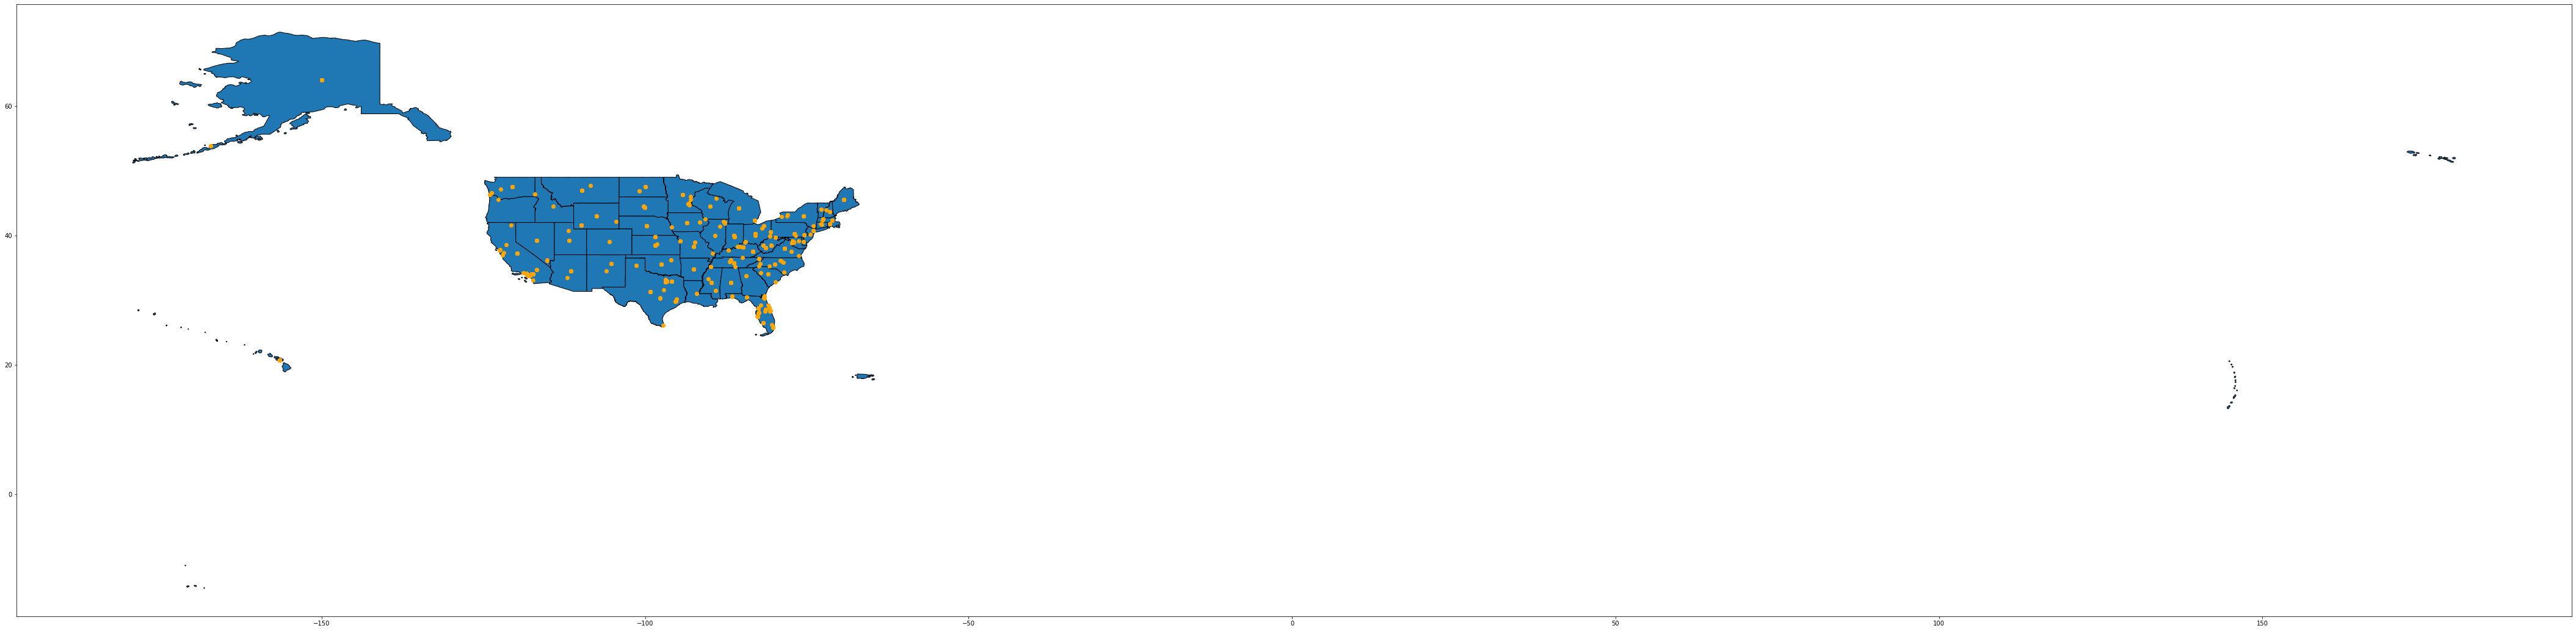

In [210]:
generate_overlay_plot(new_df, column_name='locs')

(<matplotlib.axes._subplots.AxesSubplot at 0x28f7a51d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28f7a51d0>)

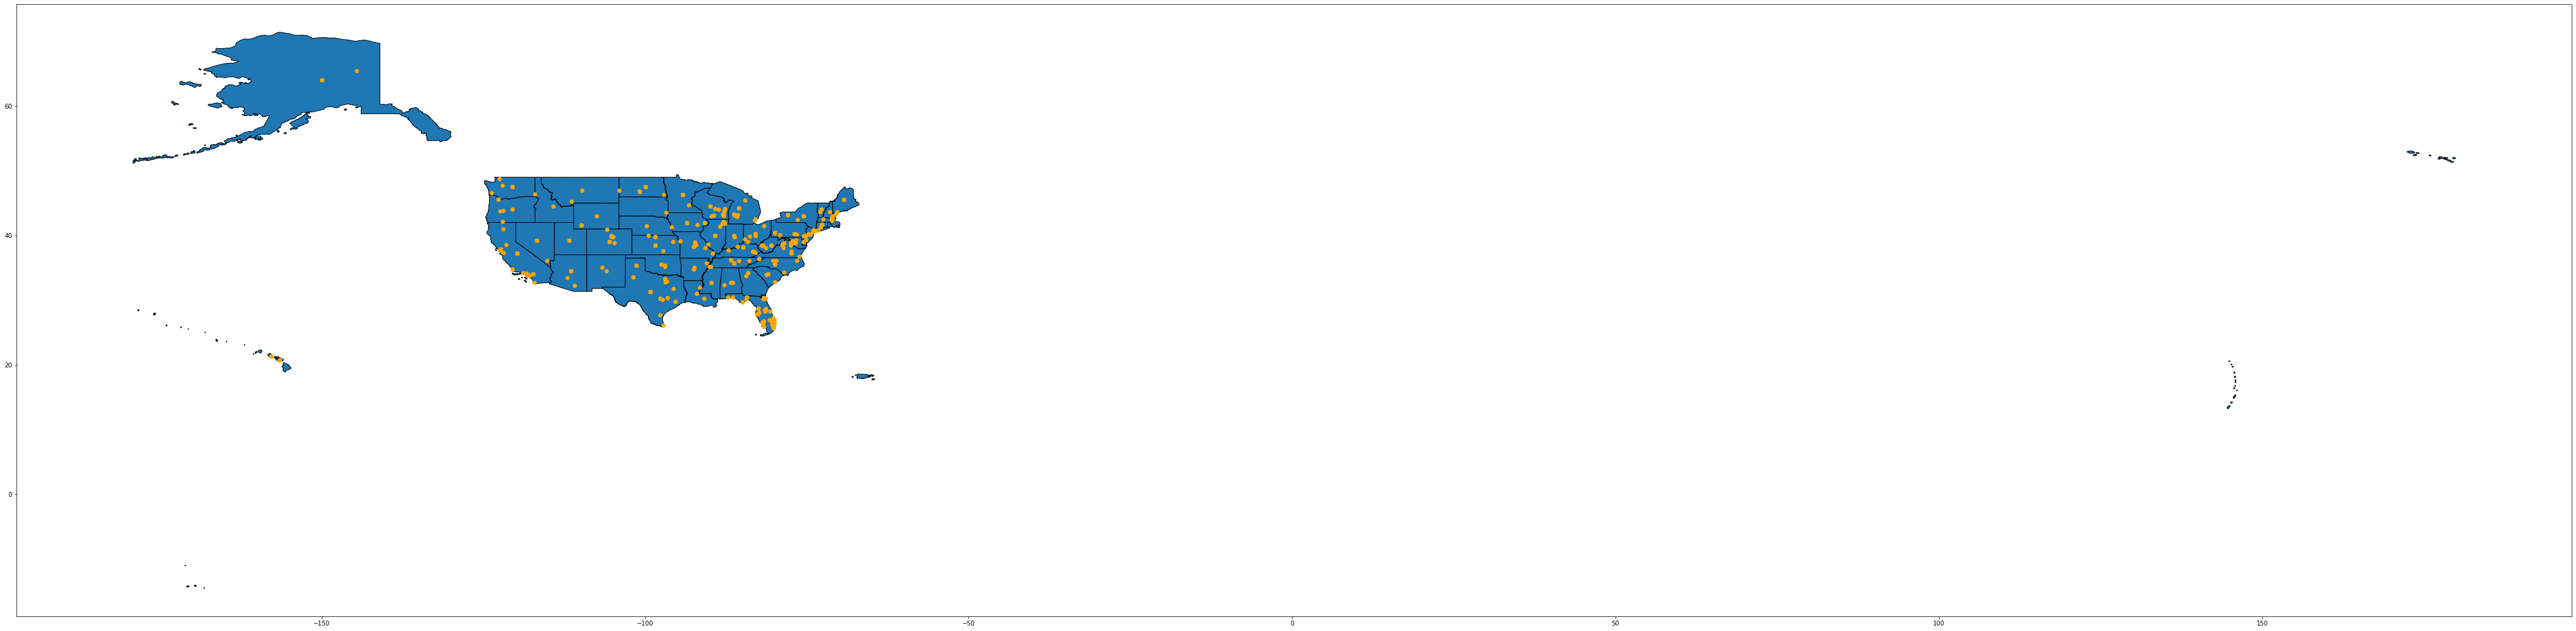

In [211]:
generate_overlay_plot(web_df, column_name='Para_Locs')

(<matplotlib.axes._subplots.AxesSubplot at 0x28fca1a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28fca1a90>)

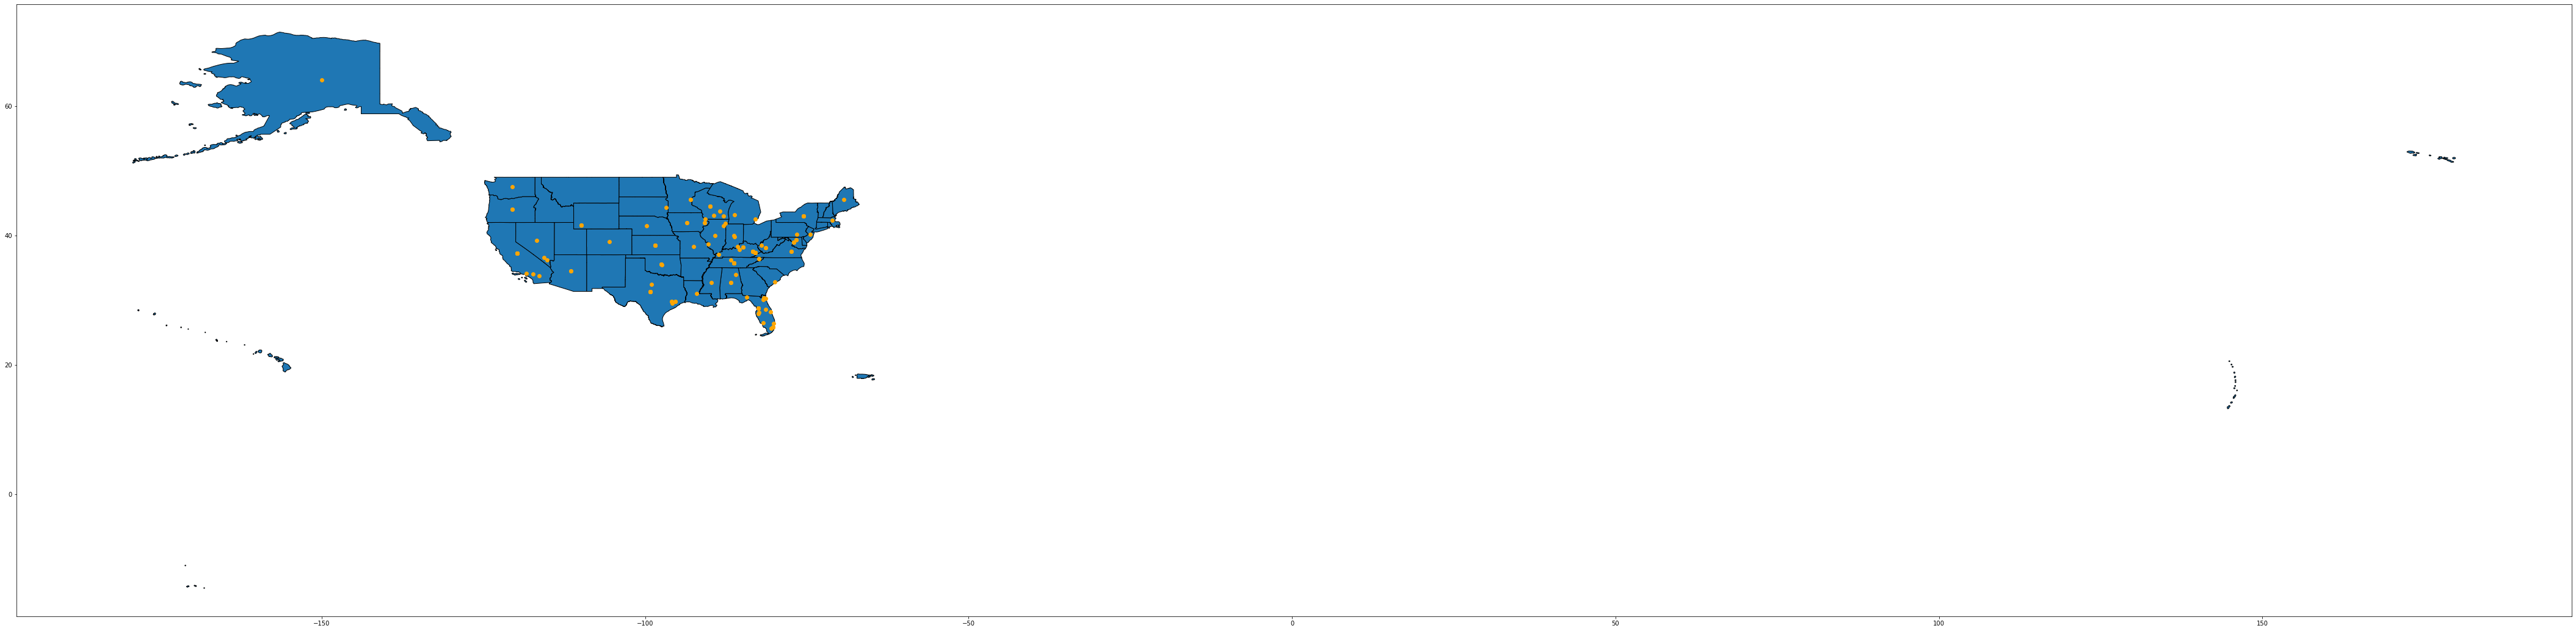

In [212]:
generate_overlay_plot(web_df, column_name='Header_Locs')

In [216]:
import plotly.graph_objects as go

# Load data frame and tidy it.
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = df['total exports'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "# of Locations",
))

fig.update_layout(
    title_text = 'Locations by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [215]:
df

,code,state,category,total exports,beef,pork,poultry,dairy,fruits fresh,fruits proc,total fruits,veggies fresh,veggies proc,total veggies,corn,wheat,cotton
0,AL,Alabama,state,1390.63,34.4,10.6,481.0,4.06,8.0,17.1,25.11,5.5,8.9,14.33,34.9,70.0,317.61
1,AK,Alaska,state,13.31,0.2,0.1,0.0,0.19,0.0,0.0,0.00,0.6,1.0,1.56,0.0,0.0,0.00
2,AZ,Arizona,state,1463.17,71.3,17.9,0.0,105.48,19.3,41.0,60.27,147.5,239.4,386.91,7.3,48.7,423.95
3,AR,Arkansas,state,3586.02,53.2,29.4,562.9,3.53,2.2,4.7,6.88,4.4,7.1,11.45,69.5,114.5,665.44
4,CA,California,state,16472.88,228.7,11.1,225.4,929.95,2791.8,5944.6,8736.40,803.2,1303.5,2106.79,34.6,249.3,1064.95
5,CO,Colorado,state,1851.33,261.4,66.0,14.0,71.94,5.7,12.2,17.99,45.1,73.2,118.27,183.2,400.5,0.00
6,CT,Connecticut,state,259.62,1.1,0.1,6.9,9.49,4.2,8.9,13.10,4.3,6.9,11.16,0.0,0.0,0.00
7,DE,Delaware,state,282.19,0.4,0.6,114.7,2.30,0.5,1.0,1.53,7.6,12.4,20.03,26.9,22.9,0.00
8,FL,Florida,state,3764.09,42.6,0.9,56.9,66.31,438.2,933.1,1371.36,171.9,279.0,450.86,3.5,1.8,78.24
9,GA,Georgia,state,2860.84,31.0,18.9,630.4,38.38,74.6,158.9,233.51,59.0,95.8,154.77,57.8,65.4,1154.07
